In [23]:
# get matplotlib configuration
%run plot_conf.py

In [24]:
import torch
from torch.autograd import Variable as V
from torch.nn.functional import softmax
from ipywidgets import FloatProgress
from IPython.display import display

In [25]:
network = dict()
network['014'] = torch.load('../results/014/model.pth.tar')

In [26]:
# model 014
model = network['014']
test_data = torch.load('../data_set_backups/test_data.tar')
r = test_data.videos[20][0]; r

(1083, 1024)

In [27]:
nb_frames = r[0] - r[1] + 1
prg_bar = FloatProgress(min=0, max=nb_frames); display(prg_bar)
x_hat_mat = torch.Tensor(nb_frames, 3, 256, 256)
x_mat = torch.Tensor(nb_frames, 3, 256, 256)
prob_mat = torch.Tensor(nb_frames, model.stabiliser.out_features)
state = None
for idx in range(nb_frames):
    (x, y) = test_data[idx + r[1]]
    x_mat[idx].copy_(x)
    (x_hat, state), (_, logit) = model(V(x.cuda().unsqueeze(0), volatile=True), state)
    x_hat_mat[idx].copy_(x_hat.data.squeeze(0))
    h_x = softmax(logit).data.squeeze(0)
    prob_mat[idx].copy_(h_x)
    prg_bar.value += 1

In [28]:
def to_view(a):
    return a.cpu().numpy().transpose((1, 2, 0))

In [29]:
def fancy_box(colour):
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    for s in plt.gca().spines.values(): s.set_color(colour)

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

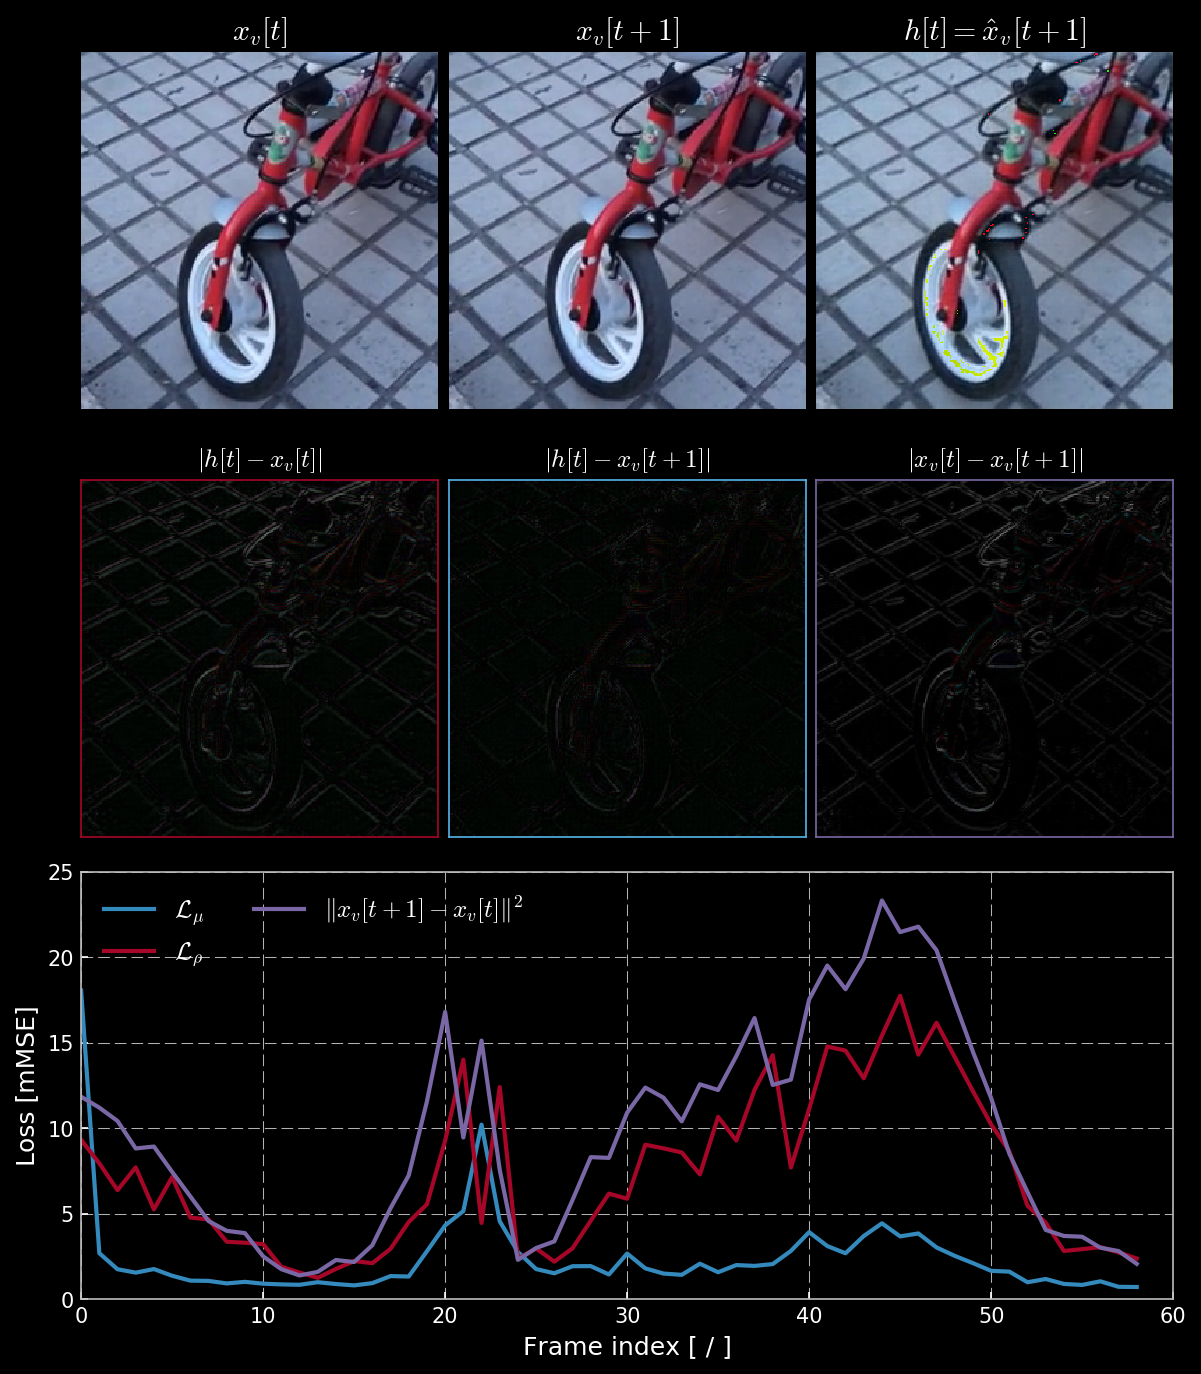

In [9]:
%matplotlib inline
plt_style('k')
fig = plt.figure(figsize=(8,9.5), dpi=150)
mse = list()
rpl_mse = list()
diff = list()
! mkdir -p MatchNet

for f in range(nb_frames - 1):

    plt.subplot(331)
    plt.imshow(to_view(x_mat[f])); plt.axis('off')
    plt.title(r'$x_v[t]$')

    plt.subplot(332)
    plt.imshow(to_view(x_mat[f+1])); plt.axis('off')
    plt.title(r'$x_v[t+1]$')

    plt.subplot(333)
    plt.imshow(to_view(x_hat_mat[f])); plt.axis('off')
    plt.title(r'$h[t] = \hat x_v[t+1]$')

    plt.subplot(334)
    plt.imshow(to_view((x_hat_mat[f] - x_mat[f]).abs())); fancy_box('C1')

    plt.title(r'$\vert h[t] - x_v[t]\vert$', fontsize=12)

    plt.subplot(335)
    plt.imshow(to_view((x_hat_mat[f] - x_mat[f+1]).abs())); fancy_box('C6')
    plt.title(r'$\vert h[t] - x_v[t+1]\vert$', fontsize=12)

    plt.subplot(336)
    plt.imshow(to_view((x_mat[f+1] - x_mat[f]).abs())); fancy_box('C2')
    plt.title(r'$\vert x_v[t] - x_v[t+1]\vert$', fontsize=12)

    plt.subplot(313)
    mse.append((x_hat_mat[f] - x_mat[f+1]).pow(2).mean() * 1e3)
    rpl_mse.append((x_hat_mat[f] - x_mat[f]).pow(2).mean() * 1e3)
    diff.append((x_mat[f] - x_mat[f+1]).pow(2).mean() * 1e3)
    plt.cla()
    plt.plot(mse)
    plt.plot(rpl_mse)
    plt.plot(diff)
    plt.legend((
        r'$\mathcal{L}_\mu$',
        r'$\mathcal{L}_\rho$',
        r'$\Vert x_v[t+1] - x_v[t]\Vert^2$',
    ),  ncol=2, frameon=False, fontsize=12, loc=2)
    plt.xlim((-2, nb_frames + 1))
    plt.axis((0, 60, 0, 25))
    plt.xlabel('Frame index [ / ]')
    plt.ylabel('Loss [mMSE]')


    plt.subplots_adjust(left=.08, bottom=0.07, right=.99, top=0.97, wspace=0.03, hspace=0)
    fig.canvas.draw()
    fig.savefig('MatchNet/{:02d}.png'.format(f), facecolor='#222222')
# fig.savefig('test.png', facecolor='#222222')

last_f = f + 1
for f in range(last_f, last_f + 20):
    fig.savefig('MatchNet/{:02d}.png'.format(f), facecolor='#222222')

# Creation of MP4, compatible with mobile devices
! ffmpeg -r 10 -i MatchNet/%02d.png -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" MatchNet.mp4

fig

In [30]:
import matplotlib.gridspec as gridspec

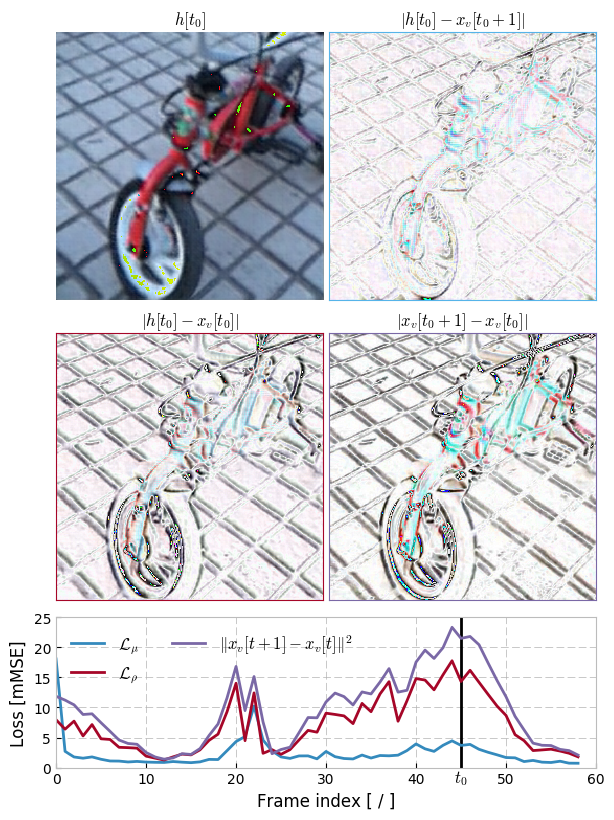

In [32]:
%matplotlib inline
plt_style('w')
fig = plt.figure(figsize=(6,8))
mse = list()
rpl_mse = list()
diff = list()

f = nb_frames - 2
ff = 45
gs = gridspec.GridSpec(3, 2, height_ratios=[1,1,.5])

plt.subplot(gs[0, 0])
plt.imshow(to_view(x_hat_mat[ff])); plt.axis('off')
plt.title(r'$h[t_0]$', fontsize=12)

plt.subplot(gs[0, 1])
plt.imshow(1-to_view((x_hat_mat[ff] - x_mat[ff+1]).abs()*2)); fancy_box('C6')
plt.title(r'$\vert h[t_0] - x_v[t_0+1]\vert$', fontsize=12)

plt.subplot(gs[1, 0])
plt.imshow(1-to_view((x_hat_mat[ff] - x_mat[ff]).abs()*2)); fancy_box('C1')
plt.title(r'$\vert h[t_0] - x_v[t_0]\vert$', fontsize=12)

plt.subplot(gs[1, 1])
plt.imshow(1-to_view((x_mat[ff+1] - x_mat[ff]).abs()*2)); fancy_box('C2')
plt.title(r'$\vert x_v[t_0+1] - x_v[t_0]\vert$', fontsize=12)

plt.subplot(gs[2, :2])
mse = ((x_hat_mat[:f+1] - x_mat[1:]).pow(2).view(f+1, -1).mean(1) * 1e3).numpy()
rpl_mse = ((x_hat_mat[1:] - x_mat[1:]).pow(2).view(f+1, -1).mean(1) * 1e3).numpy()
diff = ((x_mat[1:] - x_mat[:f+1]).pow(2).view(f+1, -1).mean(1) * 1e3).numpy()
plt.plot(mse)
plt.plot(rpl_mse)
plt.plot(diff)
plt.vlines(45, 0, 25)
plt.legend((
    r'$\mathcal{L}_\mu$',
    r'$\mathcal{L}_\rho$',
    r'$\Vert x_v[t+1] - x_v[t]\Vert^2$',
),  ncol=2, frameon=False, fontsize=12)
plt.xlabel('Frame index [ / ]')
plt.ylabel('Loss [mMSE]')
plt.axis((0, 60, 0, 25))
plt.text(45, -2.5, r'$t_0$', horizontalalignment='center', fontsize=12)

plt.subplots_adjust(left=.08, bottom=0.05, right=0.98, top=0.99, wspace=0.02, hspace=0)
fig.savefig('MatchNet.svg')

fig

In [12]:
import torchvision.transforms as transforms

In [14]:
trs_256 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Scale(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
])

In [15]:
from torch import nn
from model.Model02 import Model02 as Model

size = (3, 32, 64, 128, 256, 256, 256)
class Capsule(nn.Module):

    def __init__(self):
        super().__init__()
        self.inner_model = Model(size + (35,), (256, 256))

    def forward(self, x):
        (_, _), (_, video_index) = self.inner_model(x, None)
        return video_index

model = Capsule()


---------------------------- Building model Model02 ----------------------------
Hidden layers: 6
Net sizing: (3, 32, 64, 128, 256, 256, 256, 35)
Input spatial size: 3 x (256, 256)
Layer 1 ------------------------------------------------------------------------
Bottom size: 3 x (256, 256)
Top size: 32 x (128, 128)
Layer 2 ------------------------------------------------------------------------
Bottom size: 32 x (128, 128)
Top size: 64 x (64, 64)
Layer 3 ------------------------------------------------------------------------
Bottom size: 64 x (64, 64)
Top size: 128 x (32, 32)
Layer 4 ------------------------------------------------------------------------
Bottom size: 128 x (32, 32)
Top size: 256 x (16, 16)
Layer 5 ------------------------------------------------------------------------
Bottom size: 256 x (16, 16)
Top size: 256 x (8, 8)
Layer 6 ------------------------------------------------------------------------
Bottom size: 256 x (8, 8)
Top size: 256 x (4, 4)
Classifier ---------

In [16]:
mod_D = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('object-model02D-backup/model_best.pth.tar')
mod_D.load_state_dict(checkpoint['state_dict'])
mod_D.eval();

In [13]:
from skvideo.io import FFmpegReader

In [17]:
network['036'] = torch.load('../results/036/model.pth.tar')
object_loader = torch.load('/home/atcold/MatchNet2/test_data.tar')
vid = FFmpegReader('/home/atcold/Videos/20170418_113638.mp4')

In [18]:
vid_iter = vid.nextFrame()
nb_frames = vid.inputframenum
prg_bar = FloatProgress(min=0, max=nb_frames); display(prg_bar)
prob_mat = {
    '036': torch.Tensor(nb_frames, network['036'].stabiliser.out_features),
    'D2':  torch.Tensor(nb_frames, network['036'].stabiliser.out_features),
}
x_mat = torch.Tensor(nb_frames, 3, 256, 256)

state = None
for idx, x in enumerate(vid_iter):
    x = trs_256(x)
    x_mat[idx].copy_(x)
    (_, state), (_, logit) = network['036'](V(x.cuda().unsqueeze(0), volatile=True), state)
    h_x = softmax(logit).data.squeeze(0)
    prob_mat['036'][idx].copy_(h_x)
    logit = mod_D(V(x.cuda().unsqueeze(0), volatile=True))
    h_x = softmax(logit).data.squeeze(0)
    prob_mat['D2'][idx].copy_(h_x)
    prg_bar.value += 1

In [19]:
# Go and generate the saliency map from the salient_regions notebook
chair = torch.load('my_chair.pth')

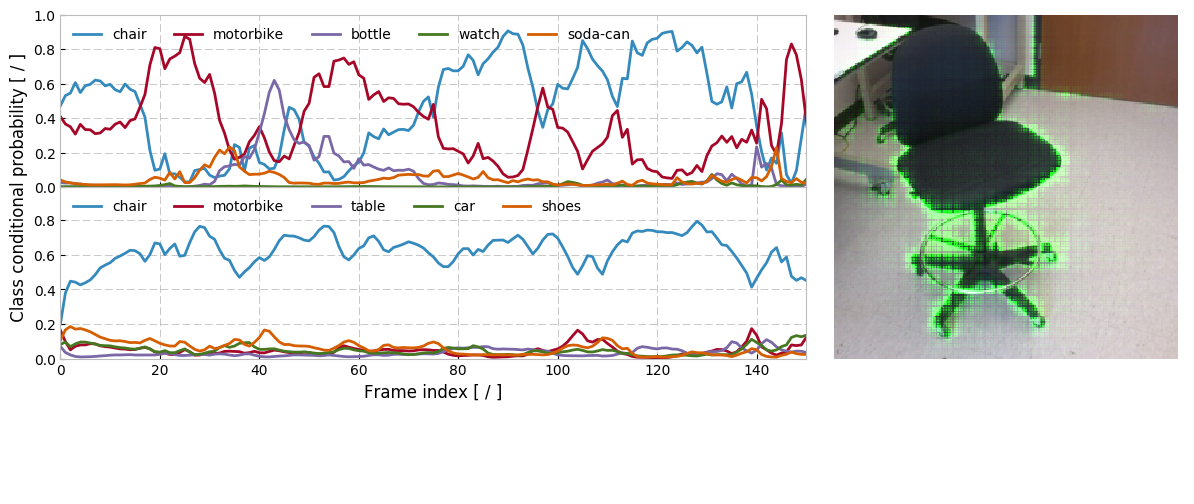

In [20]:
%matplotlib inline
plt_style('w')
fig = plt.figure(figsize=(12, 4))
nb_classes = 5

video_mean_prob = prob_mat['D2'].mean(dim=0).squeeze()
probs, idx = video_mean_prob.sort(0, True)
top_n_classes = prob_mat['D2'].index_select(1, idx[:5])
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.plot(top_n_classes.numpy())
plt.axis((0, 150, 0, 1))
plt.legend([object_loader.classes[idx[i]] for i in range(5)], ncol=5, frameon=False)

video_mean_prob = prob_mat['036'].mean(dim=0).squeeze()
probs, idx = video_mean_prob.sort(0, True)
top_n_classes = prob_mat['036'].index_select(1, idx[:5])
plt.subplot2grid((2, 3), (1, 0), colspan=2)
plt.plot(top_n_classes.numpy())
plt.legend([object_loader.classes[idx[i]] for i in range(5)],  ncol=5, frameon=False, loc='upper left')
plt.axis((0, 150, 0, 0.99))
plt.ylabel('                                 Class conditional probability [ / ]')
plt.xlabel('Frame index [ / ]')

plt.subplot2grid((2, 3), (0, 2), rowspan=2)
plt.imshow(to_view(chair), interpolation=None); plt.axis('off')

plt.subplots_adjust(left=.05, bottom=0.1, right=0.99, top=0.96, wspace=0.05, hspace=0)

fig.savefig('TempoNet.svg')

fig

In [21]:
my_chair_seq = torch.load('my_chair_seq.pth')

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

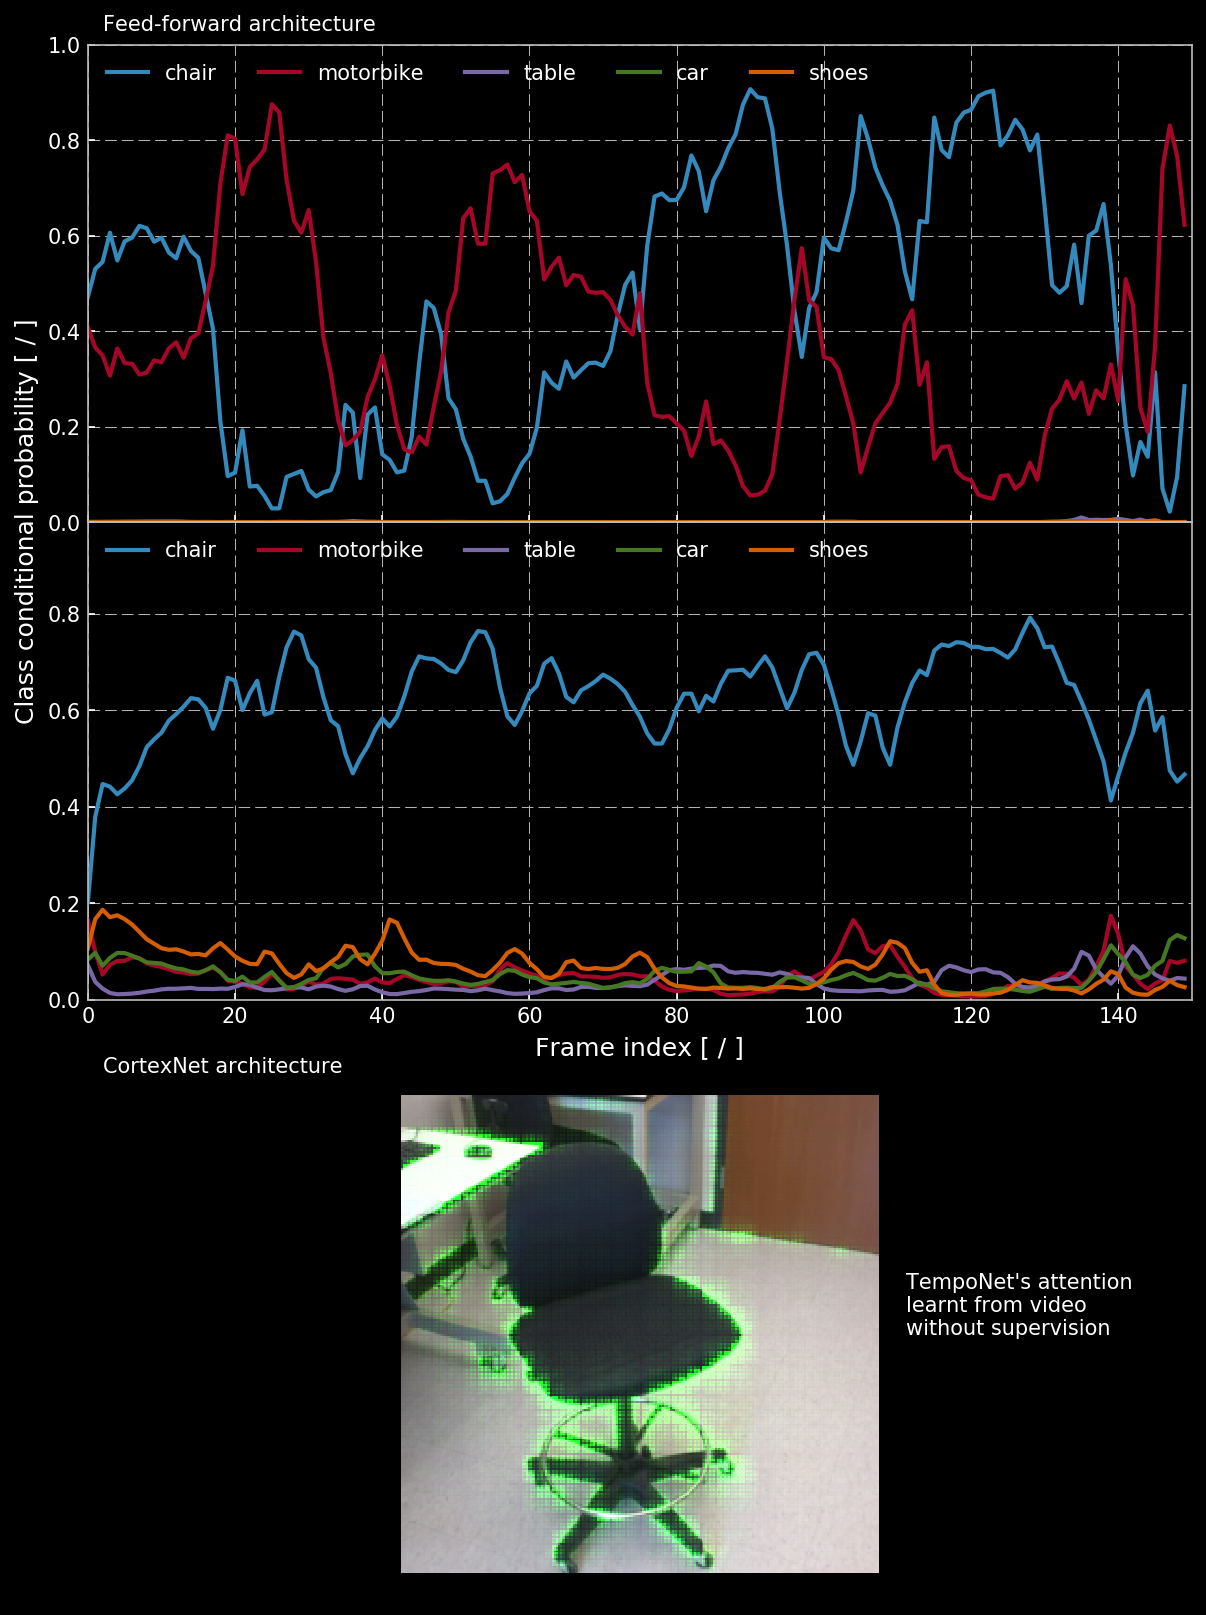

In [22]:
%matplotlib inline
plt_style('k')
fig = plt.figure(figsize=(8,10.5), dpi=150)
nb_classes = 5
! mkdir -p TempoNet

video_mean_proba = prob_mat['D2'].mean(dim=0).squeeze()
probsa, idxa = video_mean_prob.sort(0, True)
top_n_classesa = prob_mat['D2'].index_select(1, idxa[:5])

video_mean_probb = prob_mat['036'].mean(dim=0).squeeze()
probsb, idxb = video_mean_prob.sort(0, True)
top_n_classesb = prob_mat['036'].index_select(1, idx[:5])
    
for f in range(150):

    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, .2, 1])

    ax1 = plt.subplot(gs[0])
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.plot(top_n_classesa.numpy()[:f+1])
    plt.axis((0, 150, 0, 1))
    plt.legend([object_loader.classes[idx[i]] for i in range(5)], ncol=5, frameon=False, loc='upper left')
    plt.text(2, 1.03, 'Feed-forward architecture')


    plt.subplot(gs[1])
    plt.plot(top_n_classesb.numpy()[:f+1])
    plt.legend([object_loader.classes[idx[i]] for i in range(5)],  ncol=5, frameon=False, loc='upper left')
    plt.axis((0, 150, 0, 0.99))
    plt.ylabel(60*' '+'Class conditional probability [ / ]')
    plt.xlabel('Frame index [ / ]')
    plt.text(2, -0.15, 'CortexNet architecture')

    plt.subplot(gs[3])
    plt.imshow(to_view(my_chair_seq[f]), interpolation=None); plt.axis('off')
    plt.text(270, 128, 'TempoNet\'s attention\nlearnt from video\nwithout supervision')

    plt.subplots_adjust(left=.07, bottom=0, right=0.99, top=0.97, wspace=0.05, hspace=0)
    fig.canvas.draw()


    fig.savefig('TempoNet/{:02d}.png'.format(f), facecolor='#222222')
# fig.savefig('TempoNet.png'.format(f), facecolor='#222222')

last_f = f + 1
for f in range(last_f, last_f + 20):
    fig.savefig('TempoNet/{:02d}.png'.format(f), facecolor='#222222')

# Creation of MP4, compatible with mobile devices
! ffmpeg -r 10 -i TempoNet/%02d.png -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" TempoNet.mp4

fig